In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install shap

In [4]:
from datetime import datetime
import pandas as pd
import numpy as np
import xgboost as xgb
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, EditedNearestNeighbours, TomekLinks
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.model_selection import StratifiedKFold, KFold
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import shap
import matplotlib.pyplot as plt

In [29]:
base_dir = '/content/drive/MyDrive/研究所/雅涵實驗室/給學弟妹/嘉基計畫 For 致鈞&芳瑗/input/1213/'
result_dir = '/content/'
dataFolders = [
#     "struct",
#     "unigram(triage_cc)",
#     "unigram(PI)",
    # "bigram(PI)",
#     "CUI(PI)",
#     "struct + unigram(triage_cc)",
    #  "struct + unigram(PI)",
    "struct + bigram(PI)",
#     "struct + CUI(PI)",
    # "struct + unigram(triage_cc) + unigram(PI)",
#     "struct + unigram(triage_cc) + bigram(PI)",
#     "struct + unigram(triage_cc) + CUI(PI)"
]

#sampling_methods = ['SMOTETomek', 'SMOTE', 'RUS', 'ROS']
sampling_methods = {
    # 'SMOTETomek': SMOTETomek(),
    # 'SMOTE': SMOTE(),
    'RUS': RandomUnderSampler(random_state=42),
    # 'ROS': RandomOverSampler(),
}


classifiers = {
    'XGB': {
        'model': XGBClassifier(colsample_bytree=0.7,
                               learning_rate=0.01,
                               max_depth=7,
                               n_estimators=300,
                               subsample=0.7,
                               random_state=42),
    },
}

In [30]:
def compute_metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    return sensitivity, specificity

def get_results_on_test(clf, X_test, y_test, sampling_method):
    try:
        # Predict the probabilities for the test data
        y_pred_proba = clf.predict_proba(X_test)[:, 1]
        # Convert probabilities to binary predictions
        y_pred = (y_pred_proba > 0.5).astype(int)

        test_sensitivity, test_specificity = compute_metrics(y_test, y_pred)
        test_auc = roc_auc_score(y_test, y_pred_proba)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        return test_auc, test_sensitivity, test_specificity, tn, fp, fn, tp, y_test, y_pred_proba

    except Exception as e:
        print(f"Error in get_results_on_test: {str(e)}")
        return None, None, None, None, None, None, None, None, None

In [33]:
def main():
    try:
        for dataFolder in tqdm(dataFolders, desc="處理數據文件夾"):
            # 讀取數據集
            X_train = pd.read_csv(base_dir + dataFolder + '/train/X_train_pre.csv')
            y_train = pd.read_csv(base_dir + dataFolder + '/train/y_train_pre.csv').squeeze()

            # 使用預先配置的 XGBoost 模型
            model = classifiers['XGB']['model']

            # 使用採樣方法處理數據
            sampler = RandomUnderSampler()
            X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)

            # 訓練模型
            model.fit(X_resampled, y_resampled)

            # 使用 SHAP 進行特徵重要性分析
            explainer = shap.Explainer(model)
            shap_values = explainer.shap_values(X_resampled)

            # 視覺化
            shap.summary_plot(shap_values, X_resampled, show=False)
            plt.savefig(result_dir + 'shap_summary_plot.png')

            # 計算並排序特徵的平均SHAP值（重要程度）
            feature_importance = np.abs(shap_values).mean(0)
            sorted_idx = np.argsort(-feature_importance)
            sorted_feature_importance = feature_importance[sorted_idx]
            sorted_features = X_train.columns[sorted_idx]

            # 打印前幾個最重要的特徵
            num_features_to_show = 20  # 設定要顯示的特徵數量
            for idx in range(num_features_to_show):
                print(f"Feature: {sorted_features[idx]}, Importance: {sorted_feature_importance[idx]}")

            # 繪製 bar chart
            plt.figure(figsize=(10, 7))
            plt.barh(sorted_features[:num_features_to_show][::-1], sorted_feature_importance[:num_features_to_show][::-1])
            plt.xlabel('Average SHAP Value (Impact on Model Output)')
            plt.title('Top 20 Most Important Features')
            plt.savefig(result_dir + 'shap_importance_bar_chart.png')

    except Exception as e:
        print(f"發生錯誤: {e}")


處理數據文件夾:   0%|          | 0/1 [00:00<?, ?it/s][14:09:16] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[14:09:17] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Feature: v_0314C, Importance: 0.48056283593177795
Feature: lipid, Importance: 0.326803982257843
Feature: brain, Importance: 0.26581618189811707
Feature: v_0315A, Importance: 0.20879296958446503
Feature: brain compute, Importance: 0.1858833134174347
Feature: clinic follow, Importance: 0.15314163267612457
Feature: activity_x, Importance: 0.13119950890541077
Feature: htn, Importance: 0.12345655262470245
Feature: tomography, Importance: 0.10250025987625122
Feature: sbp, Importance: 0.07092008739709854
Feature: discharge, Importance: 0.06618282943964005
Feature: v_0304, Importance: 0.0565909668803215
Feature: weakness, Importance: 0.050276368856430054
Feature: fever, Importance: 0.04669122025370598
Feature: v_0306, Importance: 0.04655584320425987
Feature: compute, Importance: 0.045740921050310135
Feature: age, Importance: 0.04142671078443527
Feature: clinic, Importance: 0.04094754159450531
Feature: admission, Importance: 0.039559848606586456
Feature: outpatient, Importance: 0.03796635195612

處理數據文件夾: 100%|██████████| 1/1 [00:19<00:00, 19.50s/it]


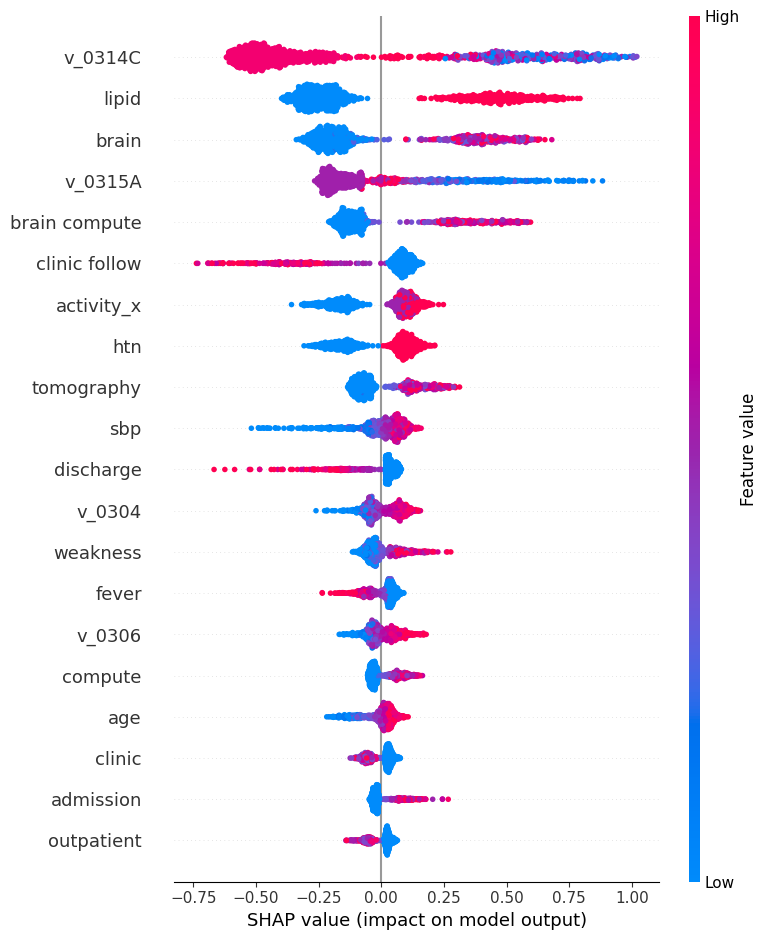

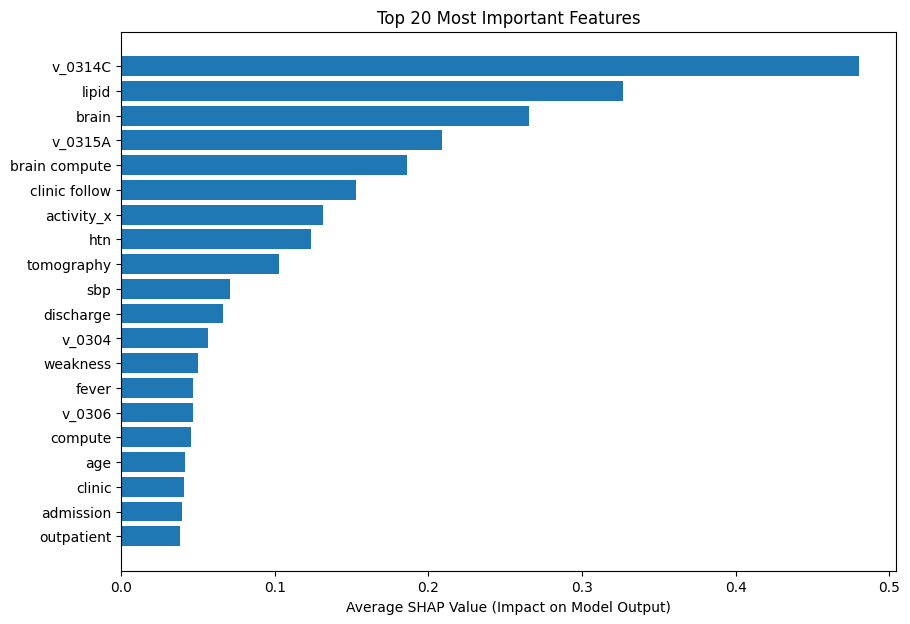

In [34]:
main()